In [1]:
import config
import sqlite3
import pandas as pd
from tqdm import tqdm
from zipfile import ZipFile
from datatable import dt, f

In [2]:
variables = pd.read_csv('data/consult/selected_variables_backup.csv')
variables

,Database,Variável,Filter,Renomear
0,sihsus,ano_internacao,ano_internacao between 2010 and 2019,ano
1,sihsus,PROC_REA,"PROC_REA in ('0310010039', '0411010034')",tipo_parto
2,sihsus,CNES,CNES is not null,cnes_hospital
3,sihsus,int_codigo_adotado,int_codigo_adotado is not null,hosp_cod_municipio
4,sihsus,int_RSAUDCOD,int_RSAUDCOD is not null,hosp_cod_regiao_saude
5,sihsus,res_codigo_adotado,res_codigo_adotado is not null,res_cod_municipio
6,sihsus,res_RSAUDCOD,res_RSAUDCOD is not null and res_RSAUDCOD != 5301,res_cod_regiao_saude
7,sihsus,def_idade_anos,def_idade_anos between 10 and 49,idade
8,sinasc,ano_nasc,ano_nasc between 2010 and 2019,ano
9,sinasc,DTNASC,DTNASC is not null,data


In [3]:
cnes_sus = set(pd.read_csv('data/consult/cnes/cnes_sus_sinasc.csv')['cnes'].values)

## Database Files

In [4]:
def get_db_zip_path(db):
	db = db.upper()
	db_zip = f'{config.PATH_DATABASES}/{db}/{db}.zip'
	if db == 'SIHSUS':
		db_zip = '/Volumes/SanDisk/SIHSUS.zip'
	return db_zip

In [5]:
def get_db_files(db):
	db_zip = get_db_zip_path(db)
	files = ZipFile(db_zip).namelist()
	files_path = [
		f'{db_zip}/{file}'for file in files if 'dict' not in file]
	return files_path

In [6]:
def get_db_variables_map(db):
	df = variables[(variables['Database'] == db)]
	return {row['Variável'] : row['Renomear']
		for _, row in df.iterrows()}

In [7]:
def get_db_variables_set(db):
	return set(variables[
		(variables['Database'] == db)
	]['Variável'].values)

## Filters

In [8]:
def filter_cnes(df):
	return df[
		(f['VINC_SUS'] == 1),
		:
	]

In [9]:
def filter_sinasc(df):
	cnes_col = df['CODESTAB'].to_list()[0]
	df = df[
		[cnes in cnes_sus for cnes in cnes_col],
		:]
	df = df[
		(
			(f['ano_nasc'] >= 2010)
			&
			(f['ano_nasc'] <= 2019)
		) & (
			(f['IDADEMAE'] >= 10)
			&
			(f['IDADEMAE'] <= 49)
		) & (
			(f['res_RSAUDCOD'] != None)
			&
			(f['res_RSAUDCOD'] != 5301)
		) & (
			(f['nasc_RSAUDCOD'] != None)
		) & (
			(f['res_codigo_adotado'] != None)
		) & (
			(f['nasc_codigo_adotado'] != None)
		) & (
			(f['def_loc_nasc'] == 'Hospital') # (f['def_loc_nasc'] == 'Hospital') (f['LOCNASC'] == 1)
		) & (
			(f['def_parto'] != 'Ignorado') # (f['def_parto'] != 'Ignorado') (f['PARTO'] != 9)
		) & (
			(f['CODESTAB'] != None)
		),
		:
	]
	return df

In [10]:
def filter_sih(df):
	return df[
		(
			(f['PROC_REA'] == 310010039)
			|
			(f['PROC_REA'] == 411010034)
		) & (
			(f['ano_internacao'] >= 2010)
			&
			(f['ano_internacao'] <= 2019)
		) & (
			(f['def_idade_anos'] >= 10)
			&
			(f['def_idade_anos'] <= 49)
		) & (
			(f['res_RSAUDCOD'] != None)
			&
			(f['res_RSAUDCOD'] != 5301)
		) & (
			(f['int_RSAUDCOD'] != None)
		) & (
			(f['res_codigo_adotado'] != None)
		) & (
			(f['int_codigo_adotado'] != None)
		) & (
			(f['CNES'] != None)
		),
		:
	]

In [11]:
def filter_df(db, df):
	df_filtered = pd.DataFrame()
	db = db.upper()
	if db == 'CNES':
		df_filtered = filter_cnes(df)
	if db == 'SINASC' and 'CODESTAB' in df.names:
		df_filtered = filter_sinasc(df)
	if db == 'SIHSUS' and 'CNES' in df.names:
		df_filtered = filter_sih(df)
	return df_filtered

## SQL DB Connection

In [12]:
def create_connection(db_file=None):
	db_file = (db_file
		if db_file else config.PATH_DB)
	try: conn = sqlite3.connect(db_file)
	except sqlite3.Error as e: print(e)
	return conn

In [13]:
def append_table_to_con(df, con, table):
	try:
		df.to_sql(
			name = table,
			con = con,
			if_exists = 'append', # append | replace
			index = False,
		)
	except Exception as excep:
		print(excep)
		print(df.columns)


In [14]:
def collect_db(db, con, chunk_size=25):
	dfs = list()
	files = get_db_files(db)
	variables = get_db_variables_set(db)
	map_cols = get_db_variables_map(db)
	for file_path in tqdm(files):
		colums = dt.fread(file_path, max_nrows=0).names
		colums = [col in variables for col in colums]
		df = dt.fread(file_path, columns=colums)
		df = filter_df(db, df)
		if df.shape[0] > 0:
			df = df.to_pandas().rename(columns=map_cols)
			dfs.append(df)
		if len(dfs) > chunk_size:
			append_table_to_con(pd.concat(dfs), con, db)
			dfs = list()
	if len(dfs) > 1:
		append_table_to_con(pd.concat(dfs), con, db)
	return True

## Run

In [15]:
db_path = f'{config.PATH_DATABASES}/PARTOS/partos.db'
with (conn := create_connection(db_path)):
	for db in ['sinasc']:#, 'cnes']:
		collect_db(db, conn)

100%|██████████| 675/675 [04:25<00:00,  2.54it/s]


- def

100%|██████████| 675/675 [05:24<00:00,  2.08it/s]

`2.48GB`

- numeros

100%|██████████| 675/675 [03:50<00:00,  2.93it/s]

`1.48GB`

- filtro cnes e numeros

100%|██████████| 675/675 [03:47<00:00,  2.97it/s]

`1.28GB`

- filtro cnes e def

100%|██████████| 675/675 [04:25<00:00,  2.54it/s]

`2.15GB`

In [43]:
conn = create_connection(db_path)

In [17]:
q = 'select count(*) from sinasc limit 5'
pd.read_sql_query(q, con=conn)

,count(*)
0,24494524


`24494524`

In [18]:
24494524-16816760

7677764

In [19]:
q = 'select * from sinasc order by cnes_hospital limit 5'
pd.read_sql_query(q, con=conn)

,cnes_hospital,idade,nivel_escolaridade,n_gestados,data,apgar1,apgar5,raca_cor,sexo_nascido,raca_cor_nascido,local_nascimento,tipo_parto,consultas_pre_natal,hosp_cod_regiao_saude,hosp_cod_municipio,res_cod_regiao_saude,res_cod_municipio,ano
0,27,32,4,1,4012010,8.0,9.0,None,Feminino,Parda,Hospital,Cesáreo,7 e mais,2601,260290,2601,260290,2010
1,27,21,5,1,19012010,8.0,9.0,None,Masculino,Parda,Hospital,Cesáreo,de 4 a 6,2601,260290,2601,260290,2010
2,27,23,4,1,3022010,9.0,10.0,None,Masculino,Parda,Hospital,Cesáreo,de 4 a 6,2601,260290,2601,260290,2010
3,27,25,4,1,27012010,8.0,9.0,None,Masculino,Parda,Hospital,Vaginal,7 e mais,2601,260290,2601,260720,2010
4,27,34,3,1,20012010,8.0,9.0,None,Feminino,Parda,Hospital,Cesáreo,de 1 a 3,2601,260290,2601,260720,2010


numeric ordinal:
- idade
- apgar1
- apgar5
- nivel_escolaridade
- indice socioeconomico regiao saude res

categoric ordinal:
- consultas_pre_natal

categoric one-hot encondig:
- tipo_parto
- raca_cor

In [20]:
conn.close()

In [36]:
ddf = pd.DataFrame()
ddf['cor'] = ['b', 'b', 'a', 'p', 'p', 'p']
ddf['idade'] = [31, 21, 24, 26, 35, 19]
ddf['escol'] = [3, 2, 0, 1, 2, 2]
y_target = pd.Series([0, 1, 1, 0, 2, 2])
ddf = pd.get_dummies(ddf)

In [37]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

In [38]:
iris = load_iris()

In [39]:
clf = DecisionTreeClassifier(random_state=0)

In [40]:
clf.fit(ddf, y_target)

DecisionTreeClassifier(random_state=0)

In [41]:
from dtreeviz.trees import dtreeviz 

/Users/lucas/Code/lucaslopes/partos/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


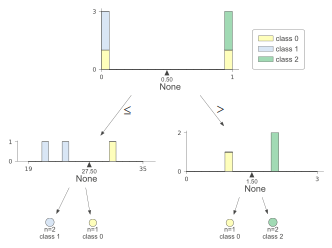

In [42]:
viz = dtreeviz(clf, ddf, y_target)
viz